In [1]:
!ls

Caso Sanitas.ipynb           Grupo Retail Hogar.docx
Dataset_Caso_SANITASF.xlsx   Rúbrica TAF.pptx
Dataset_Caso_SANITASF_2.xlsx Sanitas.docx


# Conociendo la data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df = pd.read_excel('Dataset_Caso_SANITASF_2.xlsx', sheet_name='Sheet1')

In [231]:
df = df.rename(columns=dict(zip(df.columns, map(lambda x:x.upper() ,df.columns))))

In [228]:
df.shape # 20302,200

(20261, 400)

## Analisis exploratorio las Dimensiones del Dataset

* ID: Identificador del registro

In [233]:
yyyymm_generate = lambda x,y,z:[z+str(i) for i in range(x,y+1) if i%100 in range(1,12+1)]
yyyy_generate = lambda x,y,z:[z+str(i) for i in range(x,y+1)]
null_finder = lambda x: (x.isnull()) | (x.isna())

def categorical_dist(df, c_, plot=True): # distribución de datos en una variable categórica
    df_vc = df[c_].value_counts(normalize=False, dropna=False)
    if plot:
        df_vc.plot.barh()
    display(pd.DataFrame(df_vc)
              .assign(NORM=df[c_].value_counts(normalize=True, dropna=False)*100)
              .reset_index()
              .rename(columns={'index':c_, 'NORM':'Distribución (%)', c_:'Registros'})
             )
def null_counter(df, columns):
    for c_ in columns:
        null_count_ = null_finder(df[c_]).sum()
        print(f'{c_} tiene {null_count_} nulos ({round(null_count_/df.shape[0]*100,2)}%)')

serie_to_df = lambda df, col_: (df[['ID', col_]]
                                    .rename(columns={col_:'_'.join(col_.split('_')[:-1])})
                                    .assign(DATE=col_.split('_')[-1]))        

yyyy_generate(2016,2019, 'EDAD_')

['EDAD_2016', 'EDAD_2017', 'EDAD_2018', 'EDAD_2019']

### 1. ATTRITION
* ATTRITION_MOROSIDAD_yyyymm: Deserción por dejar de pagar (yyyymm: 201601 - 202001)
* Attrition_Sistema_yyyymm: Deserción por otras razones (yyyymm: 201601 - 202001)

In [249]:
morosidad_df = (pd.concat(
                    [serie_to_df(df, col_) for col_ in yyyymm_generate(201601, 202001,'ATTRITION_MOROSIDAD_')]
                    ).reset_index(drop=True)
                  )
sistema_df = (pd.concat(
                    [serie_to_df(df, col_) for col_ in yyyymm_generate(201601, 202001,'ATTRITION_SISTEMA_')]
                    ).reset_index(drop=True)
                  )
attrition_df = morosidad_df.merge(sistema_df, on=['ID','DATE'])

In [ ]:
ax = sns.barplot(x="day", y="ATTRITION_SISTEMA_", hue="ATTRITION_MOROSIDAD_",

                 data=attrition_df, dodge=False)

In [261]:
attrition_df[['ATTRITION_MOROSIDAD','ATTRITION_SISTEMA']].value_counts(normalize=False, dropna=False)

ATTRITION_MOROSIDAD  ATTRITION_SISTEMA
0.0                  1.0                  696724
                     9.0                  255461
1.0                  9.0                   16083
                     1.0                   13001
0.0                  0.0                    6636
NaN                  NaN                    4704
1.0                  0.0                     180
dtype: int64

In [323]:
date_range = len(yyyymm_generate(201601, 202001,'ATTRITION_SISTEMA_'))
ids_no_data = len(attrition_df[attrition_df.ATTRITION_SISTEMA.isna()].ID.unique())
date_range * ids_no_data # son 96 Ids que no cuentan con attrition (Nunca se registraron)

4704

In [322]:
"""
Morosidad = {
    1: Cuando supera 90 días sin pagar
    0: Caso contrario
}
Sistema = {
    1: Si está en el portafolio
    9: No está en el portafolio
    0: Si bien está en el portafolio, se reportó cómo baja por el negocio
}
"""
attrition_df.assign(
  ATTRITION=attrition_df.apply(lambda x: (x['ATTRITION_MOROSIDAD']==1) | (x['ATTRITION_SISTEMA'] in [0,9]), axis=1)
).groupby(['ATTRITION','ATTRITION_MOROSIDAD','ATTRITION_SISTEMA']).count()['ID']

ATTRITION  ATTRITION_MOROSIDAD  ATTRITION_SISTEMA
False      0.0                  1.0                  696724
True       0.0                  0.0                    6636
                                9.0                  255461
           1.0                  0.0                     180
                                1.0                   13001
                                9.0                   16083
Name: ID, dtype: int64

In [382]:
# Se tomará un muestreo de IDs para ver el comportamiento
sample_size = 20
ids_rnd = [id_min + np.random.randint(df.ID.max()-df.ID.min()+1) for i in range(sample_size+1)]
plot_df = attrition_df[attrition_df['ID'].isin(ids_rnd)]
plot_df = plot_df.assign(
    IDX=plot_df.apply(lambda x: dict([(j,i+1) for i,j in enumerate(ids_rnd)])[x['ID']], axis=1)
)
# Transformación Morosidad
plot_df = plot_df.assign(
    ATTRITION_M=plot_df.apply(lambda x: x['IDX']*x['ATTRITION_MOROSIDAD'], axis=1)
)
# Transformación Sistema (transformación de valores, para interpretar gráficamente)
change_dict ={0:1, 9:-1, 1:0}
plot_df = plot_df.assign(
    ATTRITION_S=plot_df.apply(lambda x: x['IDX']*change_dict[x['ATTRITION_SISTEMA']], axis=1)
)

**ATRITION MOROSIDAD**

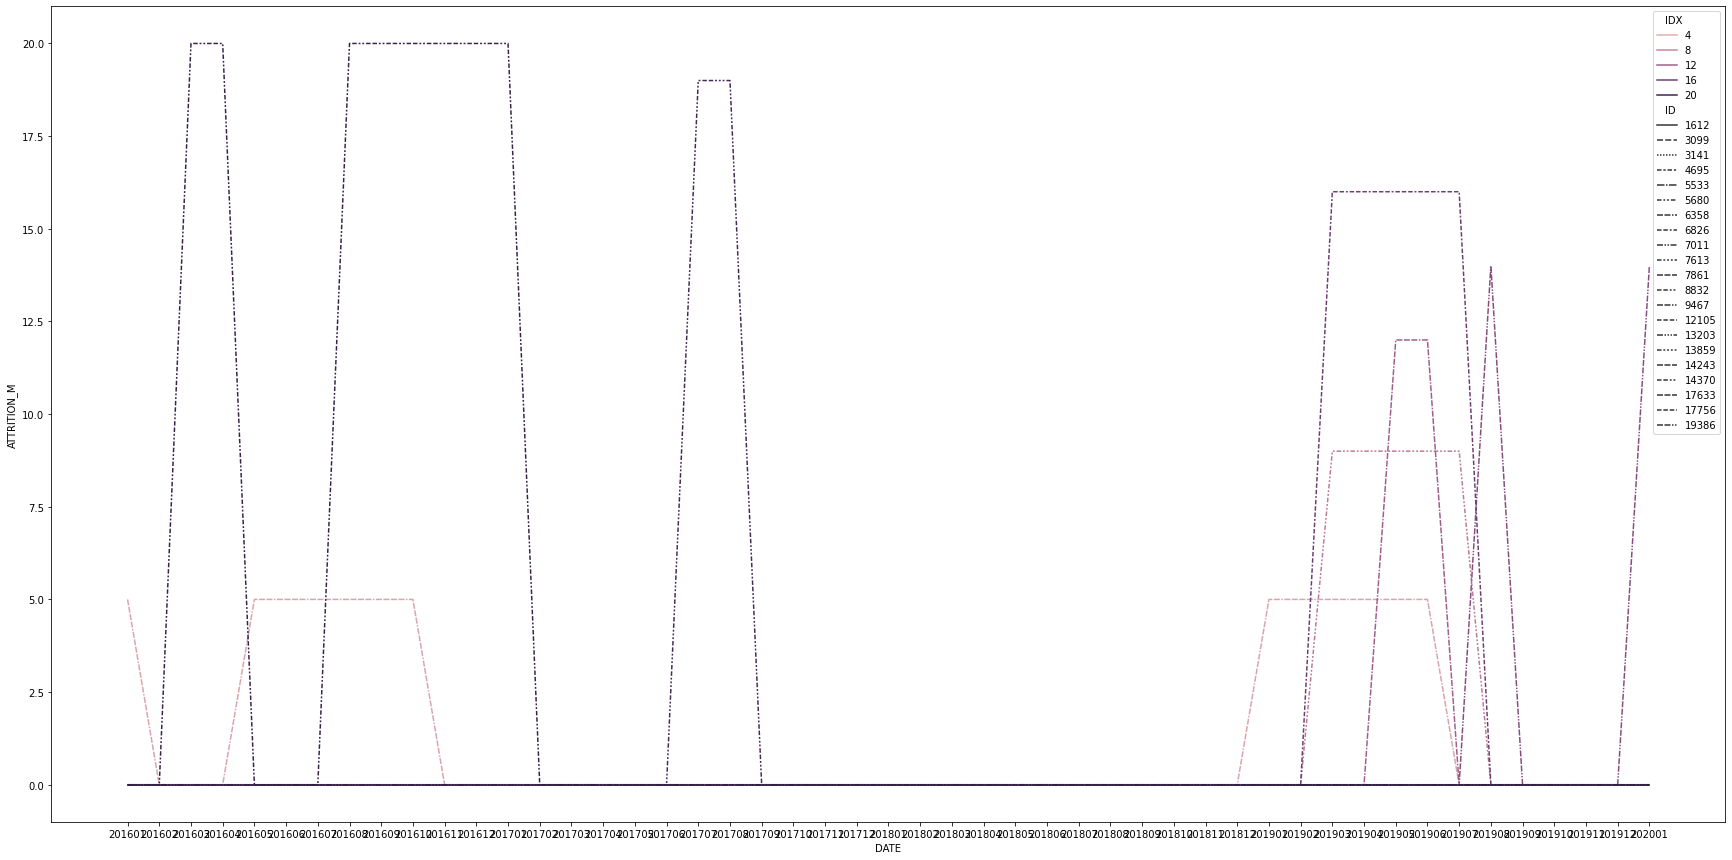

In [383]:
# Los picos son caidas en morosidad
plt.rcParams["figure.figsize"] = (30, 15)
sns.lineplot(data=plot_df, x="DATE", y="ATTRITION_M", hue="IDX", style='ID')

**ATRITION SISTEMA**

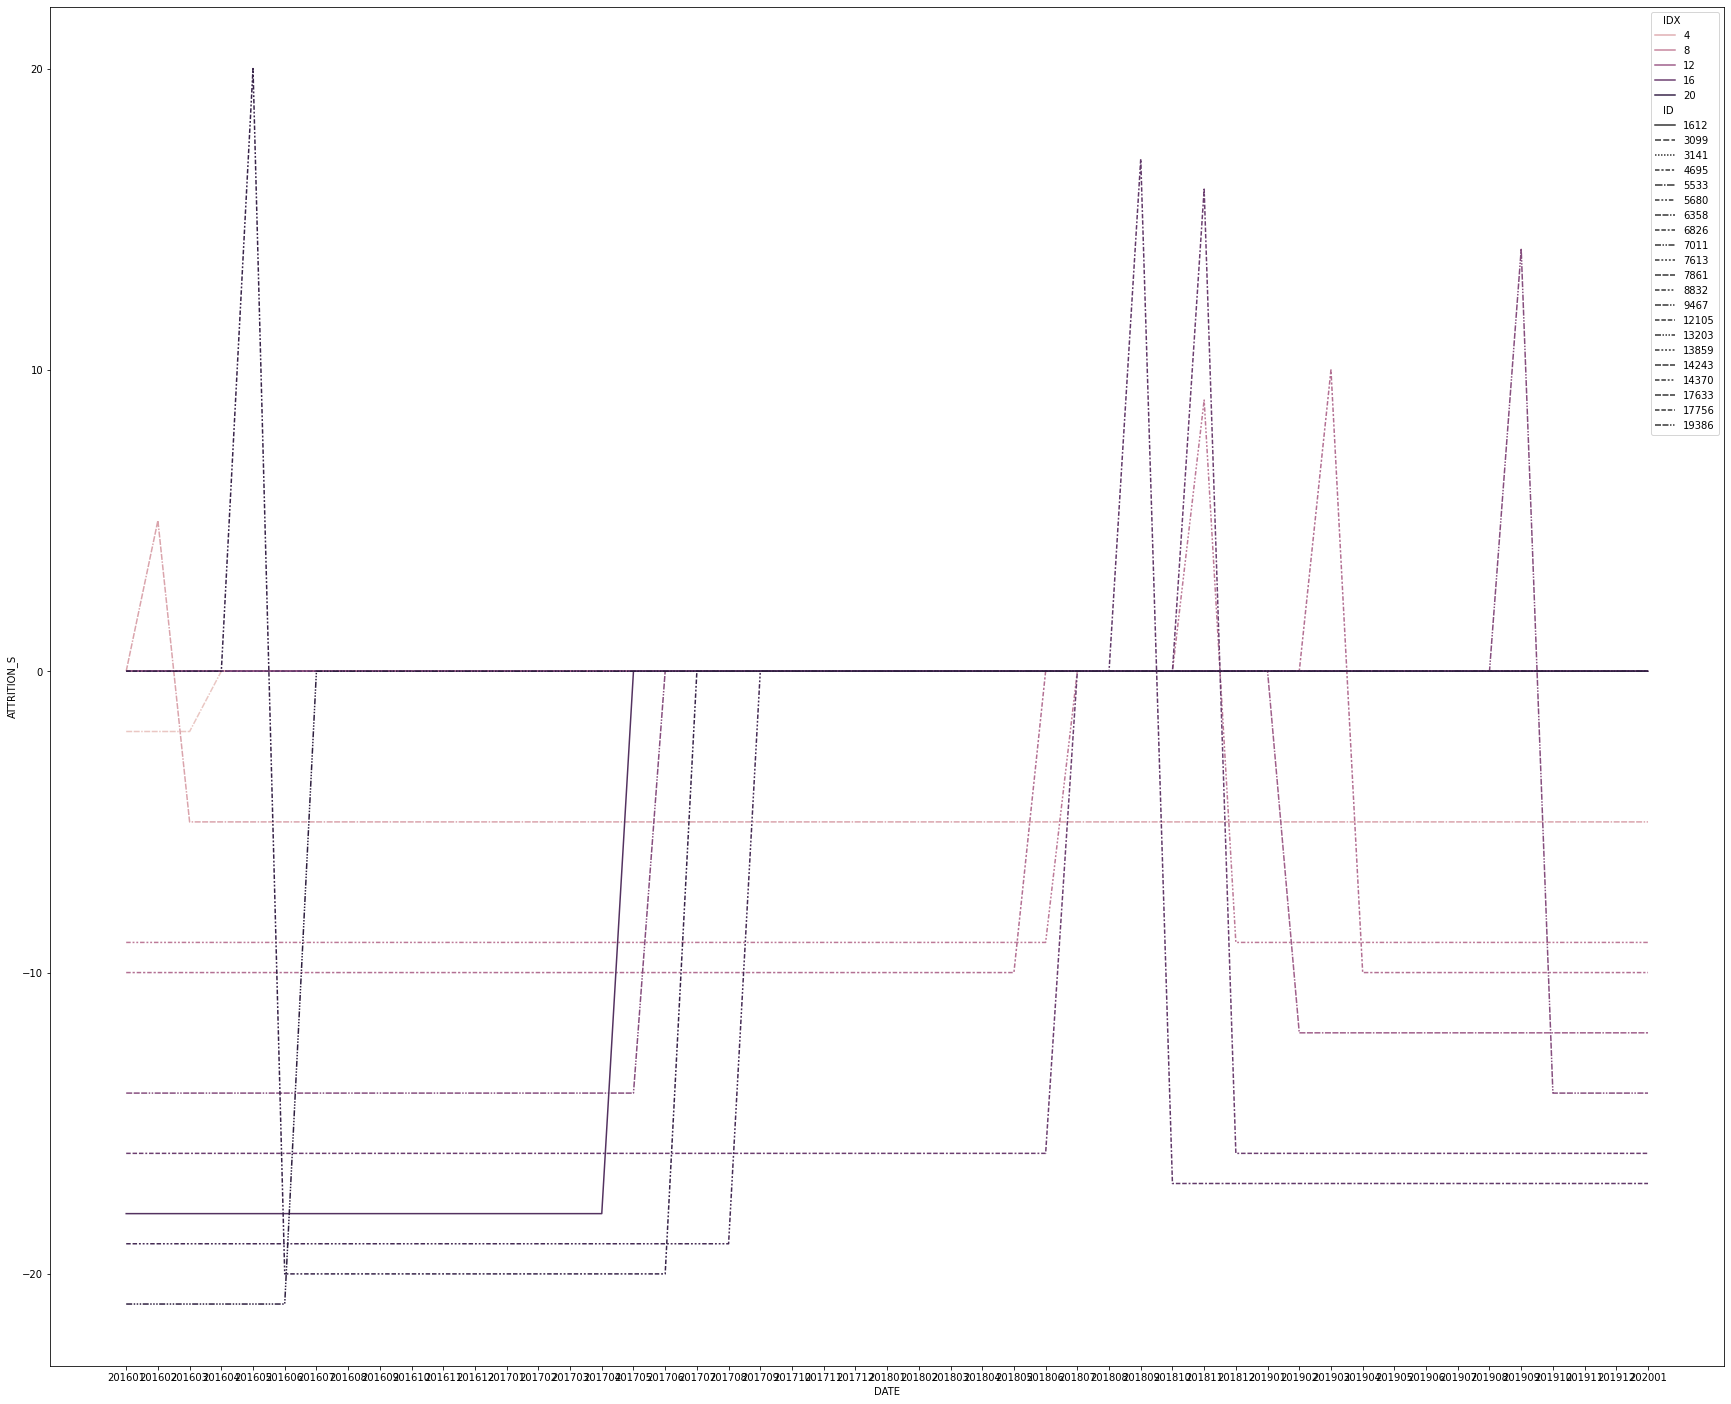

In [386]:
# (+) Picos son baja reportada por el negocio
# (-) No está en el portafolio
plt.rcParams["figure.figsize"] = (30, 25)
sns.lineplot(data=plot_df, x="DATE", y="ATTRITION_S", hue="IDX", style='ID')

**Conclusiones / Observaciones:**
1. Se observa que exactamente 96 IDs, no registran ningún dato histórico en las variables de attrition (para los 49 meses) que hacen exactamente los 4704 nan.
2. Aunque se observa una relación entre attrition morosidad y attrition sistema, estas variables no son dependientes una de otra, es decir se puede incurrir en morosidad, pero no en attrition sistema y visceversa. Nuestro prospecto ideal sería la combinación Sistema=1, Morosidad=0.
3. En attrition Morosidad, se observan que los picos no son definitivos, si bien hay leads que incurren en morosidad, en el tiempo retornan a contratar el seguro.
4. En attrition Sistema, se observa que hay una secuencia en el flujo (ciclo de vida) Se empieza cómo - (no está en el portafolio) a 0 (estar en el portafolio), a + (reportado por el negocio) y regresa a - (no estar en el portafolio)

### 2.Variables de registro del Cliente

#### 2.1 Tiempos (Edad, Alta y Afiliación)
* CODMES_ALTA: Mes de alta en Seguro
* EDAD: Edad del Periodo
* EDAD_yyyy: Edad en el año yyyy (yyyy:2016 - 2019)
* EDAD_AFIL: Edad de afilición en años
* EDAD_AFIL_MESES: Edad en meses, de afiliación del cliente 

In [634]:
# Cantidad de Nulos
cols_ = ['CODMES_ALTA','EDAD',*yyyy_generate(2016, 2019,'EDAD_'),'EDAD_AFIL','EDAD_AFIL_MESES']
null_counter(df, cols_)

CODMES_ALTA tiene 96 nulos (0.47%)
EDAD tiene 96 nulos (0.47%)
EDAD_2016 tiene 6471 nulos (31.94%)
EDAD_2017 tiene 3069 nulos (15.15%)
EDAD_2018 tiene 454 nulos (2.24%)
EDAD_2019 tiene 1439 nulos (7.1%)
EDAD_AFIL tiene 0 nulos (0.0%)
EDAD_AFIL_MESES tiene 0 nulos (0.0%)


In [635]:
# hipotesis: los 96 nulos en CODMES_ALTA podrían ser los 96 ids que no registran attrition
ids_no_attr = attrition_df[attrition_df.ATTRITION_SISTEMA.isna()].ID.unique()
null_counter(df[df.ID.isin(ids_no_attr)], cols_)

CODMES_ALTA tiene 96 nulos (100.0%)
EDAD tiene 96 nulos (100.0%)
EDAD_2016 tiene 96 nulos (100.0%)
EDAD_2017 tiene 96 nulos (100.0%)
EDAD_2018 tiene 95 nulos (98.96%)
EDAD_2019 tiene 95 nulos (98.96%)
EDAD_AFIL tiene 0 nulos (0.0%)
EDAD_AFIL_MESES tiene 0 nulos (0.0%)


In [636]:
# EDAD_AFIL linealmente dependiente con EDAD_AFIL_MESES
df[df.EDAD_AFIL_MESES//12!=df.EDAD_AFIL][['EDAD', 'EDAD_AFIL_MESES']]

,EDAD,EDAD_AFIL_MESES


In [637]:
month_diff = df.CODMES_ALTA%100-df.EDAD_AFIL_MESES%12
(df[['CODMES_ALTA','EDAD_AFIL_MESES']]
 .assign(birth_year=df.CODMES_ALTA//100-df.EDAD_AFIL_MESES//12 + month_diff.apply(lambda x: 0 if x>0 else -1))
 .assign(birth_month=month_diff.apply(lambda x: x if x>0 else 12+x))
 .assign(edad_afil_year=df.EDAD_AFIL_MESES//12)
 .assign(edad_afil_month=df.EDAD_AFIL_MESES%12)
).head(10)

,CODMES_ALTA,EDAD_AFIL_MESES,birth_year,birth_month,edad_afil_year,edad_afil_month
0,201201.0,622,1960.0,3.0,51,10
1,201803.0,793,1952.0,2.0,66,1
2,201709.0,544,1972.0,5.0,45,4
3,201405.0,565,1967.0,4.0,47,1
4,201807.0,635,1965.0,8.0,52,11
5,201607.0,481,1976.0,6.0,40,1
6,201605.0,470,1977.0,3.0,39,2
7,201705.0,467,1978.0,6.0,38,11
8,201504.0,653,1960.0,11.0,54,5
9,201803.0,631,1965.0,8.0,52,7


**Conclusiones / Observaciones:**
1. Se observa que las variables EDAD_YYYY presenta muchos nulos respecto a *COD_MES_ALTA*
2. Para conseguir la edad en cualquier instante (mes o año), se puede hacer con la combinación de *EDAD_AFIL_MESES* en conjunto con *CODMES_ALTA*
3. Como una potencial variable, se puede obtener el tiempo de afiliación que tiene el cliente, a partir de cod_mes_alta.
4. Se puede considerar sin problemas la variable SEXO, tiene una distribución cuasi equitativa F:56%-43%:M
5. Se identifican campos linealmente dependientes que podrían ser retirados sin problemas (EDAD_YYYY, EDAD, EDAD_AFIL)
6. Se observan 96 nulos en COD_MES_ALTA, son los mismos que no tienen attrition y se concluye que son leads que nunca se dieron de alta

In [396]:
# se retiran los 96 leads que no registran alta, pues no nos ayudan a determinar la fuga
df2 = df[~df.ID.isin(ids_no_attr)].reset_index(drop=True)

#### 2.2 Variables Estáticas

* SEXO: Identificativo de sexo de nacimiento (F, M)
* MACRO_REGION,DEPARTAMENTO, PROVINCIA, DISTRITO: Región, Territorio del cliente para Sanitas (ubigeo)
* CATEGORIA: Categoria del seguro (Titular,hijos, conyugue,...)
* SEGMENTO: Segmento al cual pertenece el cliente (Elite, Potencial, Regular)
* FLG_FUMADOR: Indicador si cliente es fumador (FUMA, NO FUMA)
* FREC_PAGO: Frecuencia de pago del seguro (Mensual, Anual)
* TIPO_PAGO: Indicador del tipo de pago (Credito, Debito, efectivo)
* RANGO_INGRESO_APOR: Rango de ingresos del aportante (rango de sueldo)

In [644]:
# Cantidad de Nulos
cols_ = ['SEXO', 'CATEGORIA', 'SEGMENTO', 'FLG_FUMADOR', 
         'FREC_PAGO', 'TIPO_PAGO', 'RANGO_INGRESO_APOR',
         'MACRO_REGION', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO']
null_counter(df2, cols_)

SEXO tiene 0 nulos (0.0%)
CATEGORIA tiene 0 nulos (0.0%)
SEGMENTO tiene 0 nulos (0.0%)
FLG_FUMADOR tiene 0 nulos (0.0%)
FREC_PAGO tiene 0 nulos (0.0%)
TIPO_PAGO tiene 7 nulos (0.03%)
RANGO_INGRESO_APOR tiene 1809 nulos (8.97%)
MACRO_REGION tiene 0 nulos (0.0%)
DEPARTAMENTO tiene 6 nulos (0.03%)
PROVINCIA tiene 6 nulos (0.03%)
DISTRITO tiene 6 nulos (0.03%)


In [646]:
for c_ in ['SEXO', 'CATEGORIA', 'SEGMENTO', 'FLG_FUMADOR']:
    categorical_dist(df2, c_, plot=False)

,SEXO,Registros,Distribución (%)
0,F,11361,56.340193
1,M,8804,43.659807


,CATEGORIA,Registros,Distribución (%)
0,TITULAR,13034,64.636747
1,OTROS,4597,22.796925
2,HIJO (A),1711,8.484999
3,CONYUGUE,770,3.818497
4,PADRES,53,0.262832


,SEGMENTO,Registros,Distribución (%)
0,03.POTENCIAL,5697,28.251922
1,04.REGULAR,5093,25.256633
2,01.ELITE,2910,14.430945
3,08.NBC_SI,2571,12.749814
4,02.PREFERENTE,2195,10.885197
5,05.LIMITADO,1598,7.924622
6,07.NBC_CIB,92,0.456236
7,06.NBC_CIA,9,0.044632


,FLG_FUMADOR,Registros,Distribución (%)
0,NO FUMA,17562,87.091495
1,FUMA,2603,12.908505


In [677]:
for x_ in ['CATEGORIA', 'SEGMENTO']:
    _ = ['SEXO', 'FLG_FUMADOR', x_]
    display(df2
            .fillna(value=dict(zip(_,['NA']*len(_))))
            .groupby(_, as_index=False).count()[_ + ['ID']].pivot_table('ID', _[:-1], x_))
# todos 06.NBC_CIA no fuman?

CATEGORIA         CONYUGUE  HIJO (A)  OTROS  PADRES  TITULAR
SEXO FLG_FUMADOR                                            
F    FUMA               35        26    228       3      876
     NO FUMA           448       854   2319      39     6533
M    FUMA               43        41    241       2     1108
     NO FUMA           244       790   1809       9     4517

SEGMENTO          01.ELITE  02.PREFERENTE  03.POTENCIAL  04.REGULAR  \
SEXO FLG_FUMADOR                                                      
F    FUMA            195.0          126.0         345.0       278.0   
     NO FUMA        1395.0         1069.0        2925.0      2574.0   
M    FUMA            217.0          157.0         439.0       363.0   
     NO FUMA        1103.0          843.0        1988.0      1878.0   

SEGMENTO          05.LIMITADO  06.NBC_CIA  07.NBC_CIB  08.NBC_SI  
SEXO FLG_FUMADOR                                                  
F    FUMA               102.0         NaN         4.0      118.0  
     NO FUMA            775.0         5.0        51.0     1399.0  
M    FUMA               132.0         NaN         1.0      126.0  
     NO FUMA            589.0         4.0        36.0      928.0

In [706]:
x_ = 'CATEGORIA'
_ = ['SEGMENTO', x_]
display(df2
        .fillna(value=dict(zip(_,['NA']*len(_))))
        .groupby(_, as_index=False).count()[_ + ['ID']].pivot_table('ID', _[:-1], x_))

CATEGORIA,CONYUGUE,HIJO (A),OTROS,PADRES,TITULAR
SEGMENTO,,,,,
01.ELITE,158.0,356.0,672.0,16.0,1708.0
02.PREFERENTE,104.0,232.0,513.0,6.0,1340.0
03.POTENCIAL,184.0,413.0,1355.0,14.0,3731.0
04.REGULAR,181.0,416.0,1162.0,11.0,3323.0
05.LIMITADO,38.0,127.0,385.0,3.0,1045.0
06.NBC_CIA,1.0,1.0,NaN,NaN,7.0
07.NBC_CIB,2.0,6.0,19.0,NaN,65.0
08.NBC_SI,102.0,160.0,491.0,3.0,1815.0


In [667]:
for c_ in ['FREC_PAGO', 'TIPO_PAGO', 'RANGO_INGRESO_APOR']:
    categorical_dist(df2, c_, plot=False)

,FREC_PAGO,Registros,Distribución (%)
0,01.MENSUAL,16253,80.60005
1,02.ANUAL,3912,19.39995


,TIPO_PAGO,Registros,Distribución (%)
0,CREDITO,10593,52.531614
1,DEBITO,6166,30.577734
2,EFECTIVO,3399,16.855939
3,NaN,7,0.034714


,RANGO_INGRESO_APOR,Registros,Distribución (%)
0,04.[2000 - 4000>,5619,27.865113
1,03.[1000 - 2000>,4153,20.595091
2,05.[4000 - 8000>,4094,20.302504
3,06.8000 A MÁS,2225,11.033970
4,NaN,1809,8.970989
5,02.[600 - 1000>,1798,8.916439
6,01.<600,467,2.315894


In [675]:
for x_ in ['RANGO_INGRESO_APOR']:
    _ = ['FREC_PAGO', 'TIPO_PAGO', x_]
    display(df2
            .fillna(value=dict(zip(_,['NA']*len(_))))
            .groupby(_, as_index=False).count()[_ + ['ID']].pivot_table('ID', _[:-1], x_))
# Comportamiento inverso entre tipo de pago x frecuencia

RANGO_INGRESO_APOR    01.<600  02.[600 - 1000>  03.[1000 - 2000>  \
FREC_PAGO  TIPO_PAGO                                               
01.MENSUAL CREDITO      175.0            867.0            2332.0   
           DEBITO       140.0            600.0            1365.0   
           EFECTIVO       NaN              4.0               6.0   
02.ANUAL   CREDITO        9.0             21.0              31.0   
           DEBITO         3.0              6.0              11.0   
           EFECTIVO     140.0            299.0             407.0   
           NA             NaN              1.0               1.0   

RANGO_INGRESO_APOR    04.[2000 - 4000>  05.[4000 - 8000>  06.8000 A MÁS     NA  
FREC_PAGO  TIPO_PAGO                                                            
01.MENSUAL CREDITO              3130.0            2107.0         1095.0  567.0  
           DEBITO               1704.0            1123.0          413.0  599.0  
           EFECTIVO                7.0               8.0            6.0    5.0  
02.ANUAL   CREDITO                55.0              81.0          102.0   21.0  
           DEBITO                 40.0              56.0           38.0   68.0  
           EFECTIVO              680.0             717.0          571.0  549.0  
           NA                      3.0               2.0            NaN    NaN

In [678]:
df.groupby(['SEXO', 'FLG_FUMADOR']).count()['ID']

SEXO  FLG_FUMADOR
F     FUMA            1172
      NO FUMA        10234
M     FUMA            1448
      NO FUMA         7407
Name: ID, dtype: int64

In [404]:
categorical_dist(df2, 'MACRO_REGION', plot=False) # 6 clientes no registran ubicación 

,MACRO_REGION,Registros,Distribución (%)
0,LIMA_MODERNA,7522,37.302256
1,COSTA_NORTE,2688,13.330027
2,LIMA_NORTE,1639,8.127944
3,SIERRA_SUR,1450,7.190677
4,LIMA_ESTE,1337,6.630300
5,LIMA_CENTRO,1312,6.506323
6,LIMA_SUR,1197,5.936028
7,CALLAO,781,3.873047
8,COSTA_SUR,671,3.327548
9,SIERRA_NORTE,540,2.677907


In [702]:
# quienes no registraron ubigeo si tienen mes de alta, 2 en el mismo mes pero en periodos diferentes
categorical_dist(df2[df2['MACRO_REGION']=='SIN_DATO'], 'CODMES_ALTA', plot=False)

,CODMES_ALTA,Registros,Distribución (%)
0,201406.0,2,33.333333
1,201802.0,1,16.666667
2,201102.0,1,16.666667
3,201707.0,1,16.666667
4,201806.0,1,16.666667


In [703]:
#df2[df2['MACRO_REGION']=='SIN_DATO'].T.head(400).tail(50)
#df2[df2['TIPO_PAGO'].isnull()].T.head(400).tail(50)

**Conclusiones / Observaciones:**
1. Se identifican 6 leads que no han registrado su ubigeo.
2. Se observa mayor concentración de asegurados en Lima (departamento y macro región Lima moderna), esto se presume por la mayor densidad poblacionsl que hay en Lima
3. La varible de mayor nulidad en este grupo es el rango de ingresos, se plantea cómo hipotesis identificar una relación entre el pago y frec de pago para estimar el rango de ingresos.
3. Las mujeres tienen más probabilidad de ser fumadoras, 11% vs 9%. Aunque las mujeres representan el 56% vs 44% varones
4. 


### 3. VP Value

Modelo actuarial a 10 años
* vp_primas
* vp_siniestros
* vp_tecnico
* vp_gastos
* VP_OPERATIVO

In [431]:
df2[list(filter(lambda x: x.startswith('VP'), df2.columns))].describe()

,VP_PRIMAS,VP_SINIESTROS,VP_TECNICO,VP_GASTOS,VP_OPERATIVO
count,20165.000000,20165.000000,20165.000000,20165.000000,20165.000000
mean,5284.072991,3326.408760,1903.952684,1001.217049,903.076164
std,5992.168170,7571.044645,5550.447662,894.302518,5529.449298
min,225.837050,25.755638,-116059.050000,56.057346,-119612.020000
25%,1475.830300,279.316930,985.379520,416.023160,486.498080
50%,2815.303500,1012.149400,1586.284500,683.316960,910.177670
75%,6564.900900,3172.298800,3283.794700,1253.675300,2131.070100
max,42315.637000,125411.560000,28740.230000,11069.376000,23367.838000


<AxesSubplot:>

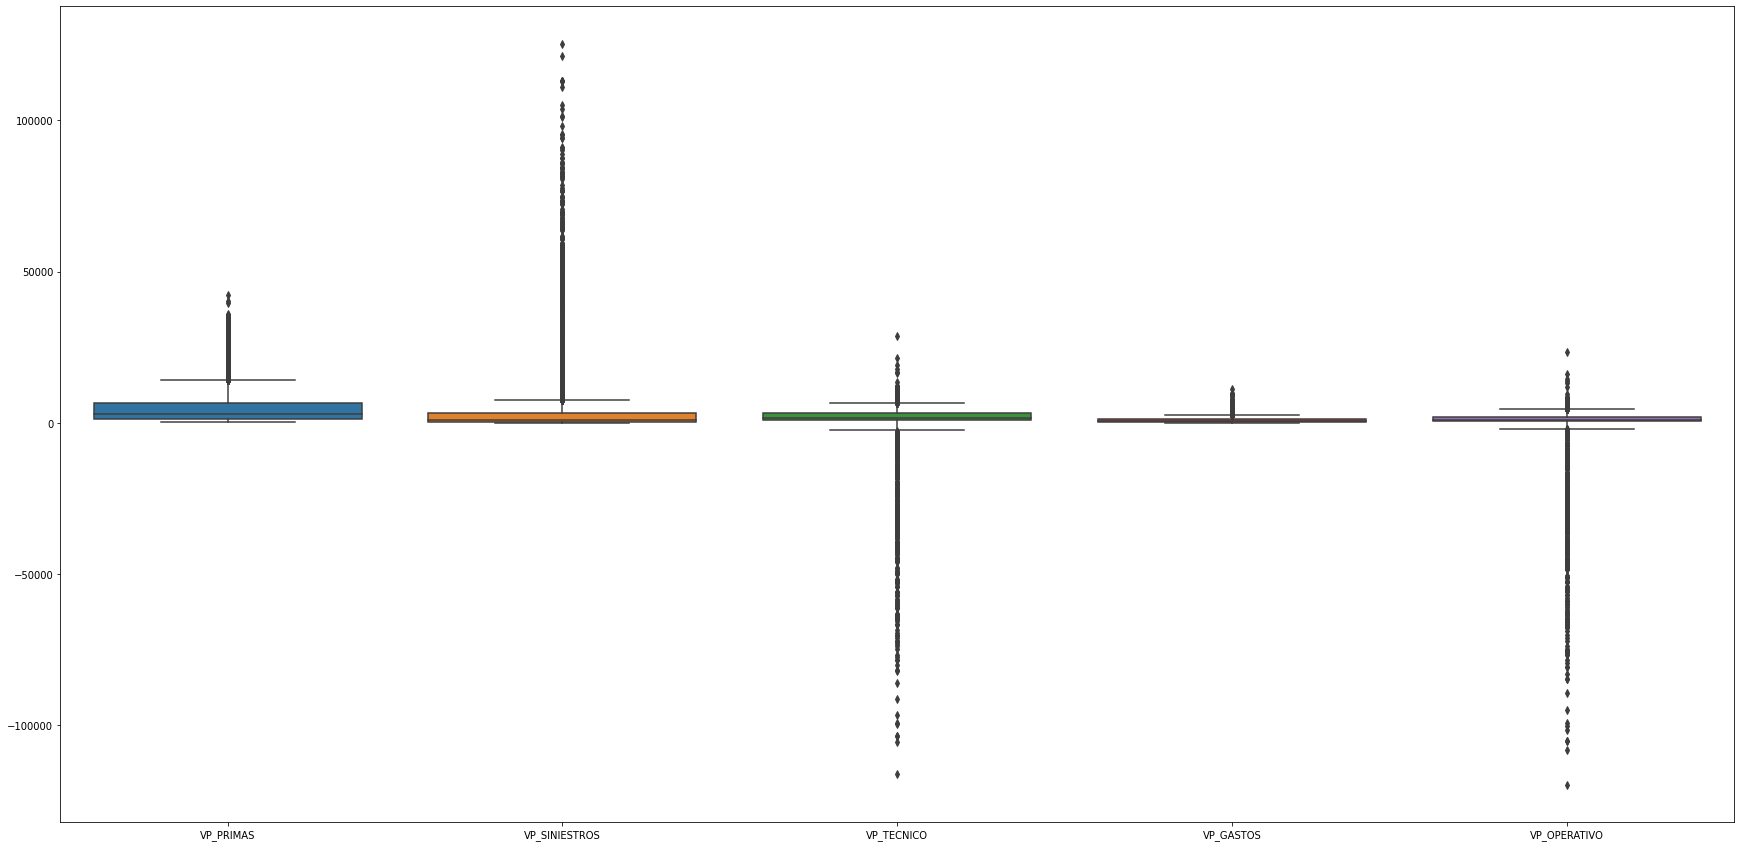

In [496]:
plt.rcParams["figure.figsize"] = (30, 15)
sns.boxplot(data=df2[list(filter(lambda x: x.startswith('VP'), df2.columns))])

In [592]:
df2.EDAD_AFIL_MESES

0        622
1        793
2        544
3        565
4        635
        ... 
20160     19
20161    250
20162     44
20163    367
20164    575
Name: EDAD_AFIL_MESES, Length: 20165, dtype: int64

In [595]:
df_vp = df2[list(filter(lambda x: x.startswith('VP'), df2.columns))].assign(
    REGISTER_MONTHS_AGE=df2.EDAD_AFIL_MESES
)
df_vp = df_vp.assign(
    MONTHS_INSURED=2020*12+1 - (df2.CODMES_ALTA//100)*12-(df2.CODMES_ALTA%100) #ult mes 202001
)
df_vp = df_vp.assign(
    CURRENT_MONTHS_AGE=df_vp.MONTHS_INSURED + df2.EDAD_AFIL_MESES
)
df_vp = df_vp.assign(
    INSURED=df_vp.MONTHS_INSURED/12,
    REGISTER_AGE=df_vp.REGISTER_MONTHS_AGE/12,
    CURRENT_AGE=df_vp.CURRENT_MONTHS_AGE/12
)

In [596]:
df_vp.CURRENT_MONTHS_AGE.value_counts(normalize=True, bins=6) # group by 232 from 0

(426.333, 635.5]       0.301066
(217.167, 426.333]     0.275378
(6.744, 217.167]       0.219886
(635.5, 844.667]       0.150855
(844.667, 1053.833]    0.048054
(1053.833, 1263.0]     0.004761
Name: CURRENT_MONTHS_AGE, dtype: float64

In [597]:
df_vp.MONTHS_INSURED.value_counts(normalize=True, bins=6) # group by 56 from 0

(-0.337, 56.0]    0.550012
(56.0, 112.0]     0.319068
(112.0, 168.0]    0.106571
(168.0, 224.0]    0.023754
(224.0, 280.0]    0.000397
(280.0, 336.0]    0.000198
Name: MONTHS_INSURED, dtype: float64

In [598]:
df_vp.REGISTER_MONTHS_AGE.value_counts(normalize=True, bins=6) # group by 180 from 0

(359.333, 539.0]      0.278205
(-1.079, 179.667]     0.241012
(179.667, 359.333]    0.239772
(539.0, 718.667]      0.177783
(718.667, 898.333]    0.055988
(898.333, 1078.0]     0.007240
Name: REGISTER_MONTHS_AGE, dtype: float64

In [626]:
"""

"""
import numpy as np
for c_ in ['CURRENT_AGE', 'INSURED', 'REGISTER_AGE']:
    _ = df_vp[c_].value_counts(normalize=True, bins=6).index.to_list()
    print(c_, ': ', sorted([np.ceil(np.abs(i.left)) for i in _] + [np.ceil(_[-1].right)]))

CURRENT_AGE :  [1.0, 19.0, 36.0, 53.0, 71.0, 88.0, 106.0]
INSURED :  [1.0, 5.0, 10.0, 14.0, 19.0, 24.0, 28.0]
REGISTER_AGE :  [1.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0]


In [522]:
plt.rcParams["figure.figsize"] = (30, 10)
vp_cols = ['VP_PRIMAS','VP_SINIESTROS','VP_TECNICO','VP_GASTOS','VP_OPERATIVO']

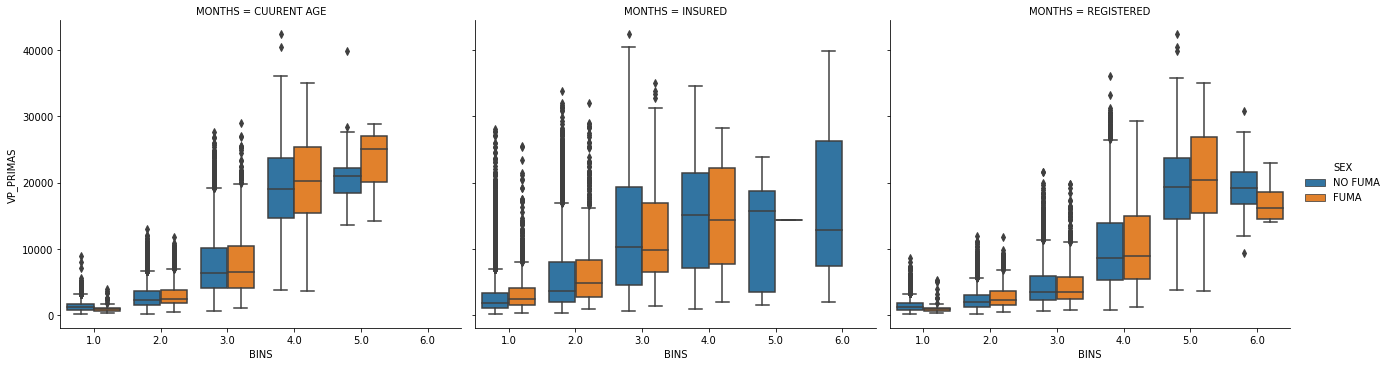

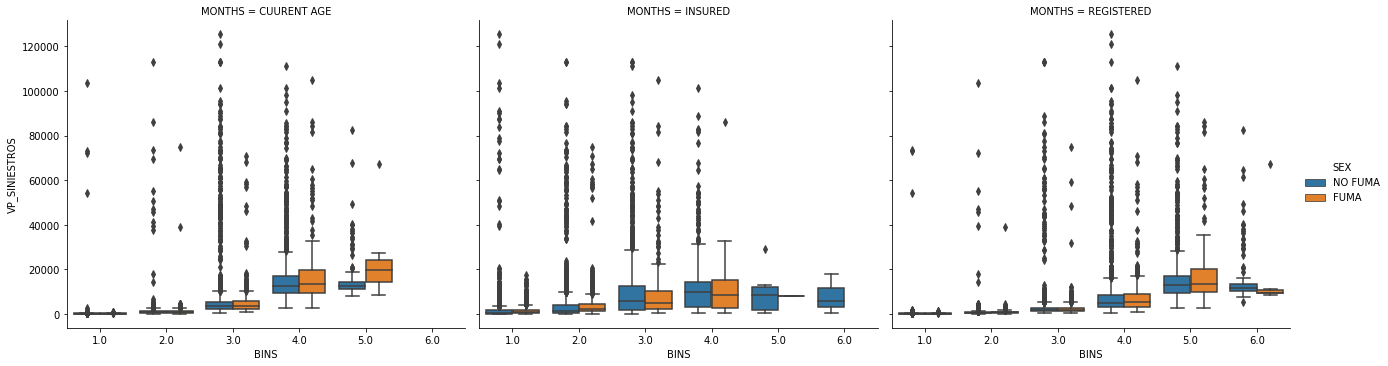

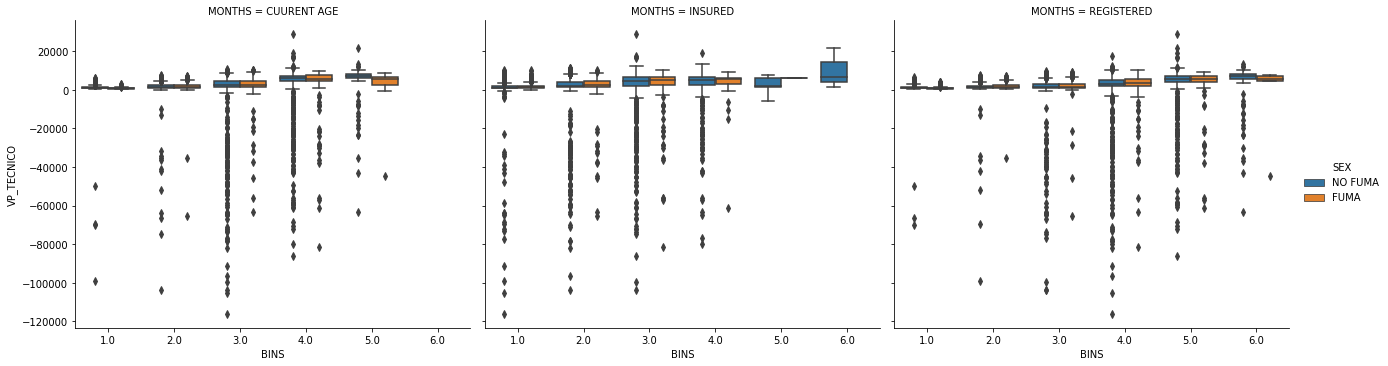

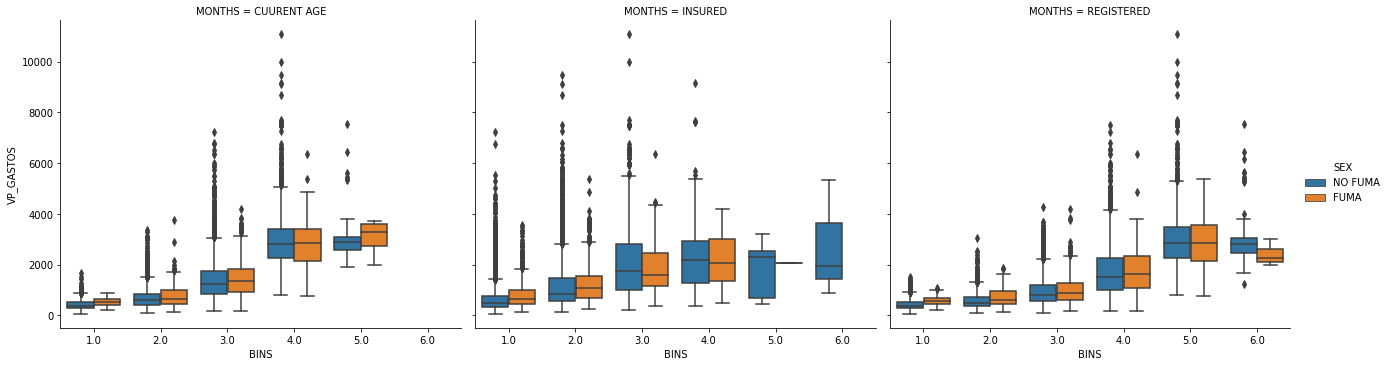

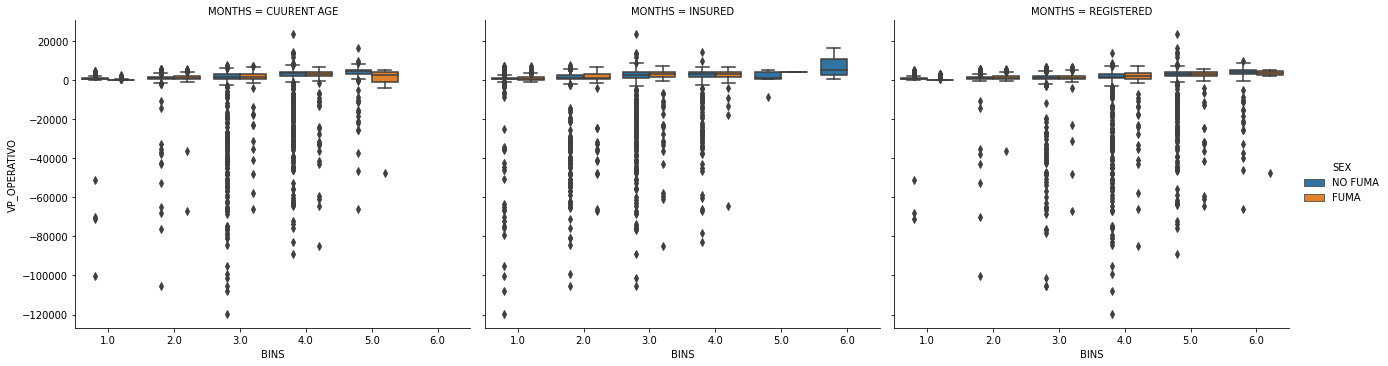

In [601]:
for vp_col in vp_cols:
    sns.catplot(data=pd.concat([(df_vp
                                 .assign(BINS=(df_vp['CURRENT_MONTHS_AGE']//259+1))
                                 .assign(MONTHS='CUURENT AGE')
                                 .assign(SEX=df2['FLG_FUMADOR'])),
                                (df_vp
                                 .assign(BINS=((df_vp['MONTHS_INSURED']//56)%6+1))
                                 .assign(MONTHS='INSURED')
                                 .assign(SEX=df2['FLG_FUMADOR'])),
                                (df_vp
                                 .assign(BINS=(((df_vp['REGISTER_MONTHS_AGE'])//180)+1))
                                 .assign(MONTHS='AFFILIATION')
                                 .assign(SEX=df2['FLG_FUMADOR']))
                               ]),
                x='BINS', y=vp_col, col='MONTHS', hue='SEX',
                aspect=1.2, kind='box' #alpha=0.2 
           )
    plt.show()
# BINS ----------|   1  |   2  |   3  |   4  |   5  |   6  |
# CURRENT AGE = [1.0,  19.0,  36.0,  53.0,  71.0,  88.0, 106.0] years
# INSURED     = [1.0,   5.0,  10.0,  14.0,  19.0,  24.0,  28.0] years
# REGISTERED  = [1.0,  15.0,  30.0,  45.0,  60.0,  75.0,  90.0] years

**Conclusiones / Observaciones:**
1. Los valores VP, son únicos para cada lead. Es decir no se cuenta con su variación histórica considerando que hay casos de desafiliación y reafiliación.
2. VP_PRIMAS, VP_SINIESTROS y VP_GASTOS tienen tendencia positiva de outliers, mientras que  VP_TECNICO y VP_OPERATIVA tanto positiva, como negativa pero mayor tendencia negativa.
3. 

### 4. Variables estáticas del cliente



In [439]:
# Cantidad de Nulos
cols_ = ['MACRO_REGION', 'DEPARTAMENTO','PROVINCIA','DISTRITO', 
         'FLG_FUMADOR','FREC_PAGO', 'TIPO_PAGO', 'RANGO_INGRESO_APOR'
        ]
null_counter(df2, cols_)

MACRO_REGION tiene 0 nulos (0.0%)
DEPARTAMENTO tiene 6 nulos (0.03%)
PROVINCIA tiene 6 nulos (0.03%)
DISTRITO tiene 6 nulos (0.03%)
FLG_FUMADOR tiene 0 nulos (0.0%)
FREC_PAGO tiene 0 nulos (0.0%)
TIPO_PAGO tiene 7 nulos (0.03%)
RANGO_INGRESO_APOR tiene 1809 nulos (8.97%)


In [450]:
pagos_df = (pd.concat(
                    [serie_to_df(df2, col_) for col_ in yyyymm_generate(201601, 202001,'PAGO_')]
                    ).reset_index(drop=True)
                  )

In [467]:
m_ = pagos_df[pagos_df.PAGO.isna()].groupby(['ID'], as_index=False).count()#.sort_values(['DATE'], ascending=False)
attrition_df[attrition_df.ID.isin(list(m_[m_['DATE']==49].ID.unique()))].groupby(['ATTRITION_MOROSIDAD', 'ATTRITION_SISTEMA']).count()

ID  DATE
ATTRITION_MOROSIDAD ATTRITION_SISTEMA            
0.0                 0.0                   9     9
                    1.0                 892   892
                    9.0                1959  1959
1.0                 1.0                  18    18
                    9.0                  13    13

### 3. Variables del Cliente respecto al Seguro
* TAMAÑO_GF_yyyymm: Tamaño de grupo familiar al que pertenece el afiliado, al mes de corte (yyyymm: 201601 - 202001)
* PORCENTAJE_BAJAS_GF_yyyymm: Porcentaje de bajas del grupo familiar al mes de corte (yyyymm: 201601 - 202001)

In [432]:
cols_ = ['CATEGORIA','SEGMENTO','FLG_FUMADOR']
null_counter(df2, cols_)

CATEGORIA tiene 0 nulos (0.0%)
SEGMENTO tiene 0 nulos (0.0%)
FLG_FUMADOR tiene 0 nulos (0.0%)


#### 3.1 Categóricas Únicas

CATEGORIA, SEGMENTO, FLG_FUMADOR sin nulos, se evalua distribución de valores

#### 3.1 Series

TAMAÑO_GF_yyyymm PORCENTAJE_BAJAS_GF_yyyymm, presentan nulos y una aparente evolución a lo largo del tiempo

In [433]:
cols_ = [*yyyymm_generate(201601, 202001,'TAMAÑO_GF_'),
         *yyyymm_generate(201601, 202001,'PORCENTAJE_BAJAS_GF_')]
null_counter(df2, cols_)

TAMAÑO_GF_201601 tiene 8819 nulos (43.73%)
TAMAÑO_GF_201602 tiene 8676 nulos (43.03%)
TAMAÑO_GF_201603 tiene 8555 nulos (42.42%)
TAMAÑO_GF_201604 tiene 8377 nulos (41.54%)
TAMAÑO_GF_201605 tiene 8178 nulos (40.56%)
TAMAÑO_GF_201606 tiene 7979 nulos (39.57%)
TAMAÑO_GF_201607 tiene 7771 nulos (38.54%)
TAMAÑO_GF_201608 tiene 7566 nulos (37.52%)
TAMAÑO_GF_201609 tiene 7323 nulos (36.32%)
TAMAÑO_GF_201610 tiene 7058 nulos (35.0%)
TAMAÑO_GF_201611 tiene 6481 nulos (32.14%)
TAMAÑO_GF_201612 tiene 6298 nulos (31.23%)
TAMAÑO_GF_201701 tiene 6418 nulos (31.83%)
TAMAÑO_GF_201702 tiene 6229 nulos (30.89%)
TAMAÑO_GF_201703 tiene 6029 nulos (29.9%)
TAMAÑO_GF_201704 tiene 5835 nulos (28.94%)
TAMAÑO_GF_201705 tiene 5593 nulos (27.74%)
TAMAÑO_GF_201706 tiene 5372 nulos (26.64%)
TAMAÑO_GF_201707 tiene 5112 nulos (25.35%)
TAMAÑO_GF_201708 tiene 4861 nulos (24.11%)
TAMAÑO_GF_201709 tiene 4554 nulos (22.58%)
TAMAÑO_GF_201710 tiene 3979 nulos (19.73%)
TAMAÑO_GF_201711 tiene 3610 nulos (17.9%)
TAMAÑO_GF_2017

In [413]:
serie_gf_df = (pd.concat(
                    [serie_to_df(df, col_) for col_ in yyyymm_generate(201601, 202001,'TAMAÑO_GF_')]
                ).reset_index(drop=True)
              )

In [414]:
serie_gf_df.TAMAÑO_GF.value_counts(bins=7, dropna=True)

(0.436, 81.429]       749037
(81.429, 161.857]       1604
(483.571, 564.0]         779
(403.143, 483.571]       533
(161.857, 242.286]       485
(322.714, 403.143]       235
(242.286, 322.714]       163
Name: TAMAÑO_GF, dtype: int64

<AxesSubplot:xlabel='TAMAÑO_GF'>

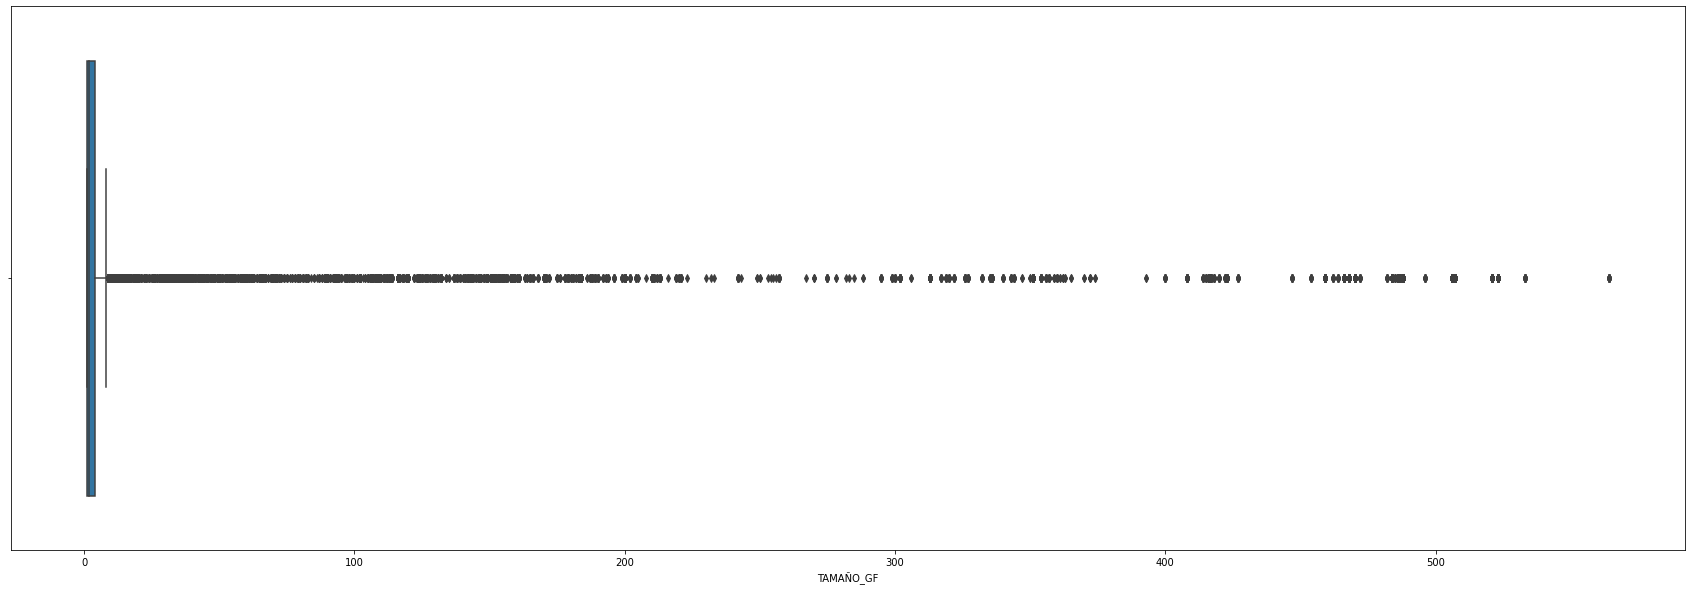

In [198]:
sns.boxplot(x=serie_gf_df.TAMAÑO_GF[~serie_gf_df.TAMAÑO_GF.isnull()])

In [193]:
serie_gf_df.shape[0]==49*df.shape[0] # 49 fechas entre 201601 & 202001

True

In [197]:
serie_gf_df[serie_gf_df.TAMAÑO_GF.between(0, 81)] # nulos

,ID,TAMAÑO_GF,DATE
1,43,1.0,201601
3,45,2.0,201601
8,50,3.0,201601
10,52,5.0,201601
11,53,1.0,201601
...,...,...,...
992782,20296,4.0,202001
992785,20299,6.0,202001
992786,20300,2.0,202001
992787,20301,9.0,202001


In [181]:
#749720+1393+1136+345+242=752836

(992789, 3)

<AxesSubplot:xlabel='TAMAÑO_GF_202001'>

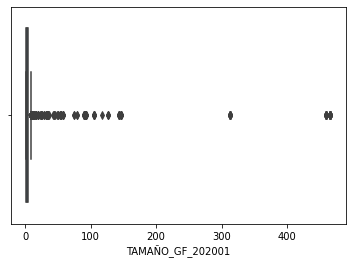

In [470]:
sns.boxplot(x=df.TAMAÑO_GF_202001[~df.TAMAÑO_GF_202001.isnull()])

In [171]:
id_min, id_max = 42, 20302
ids_rnd = [id_min + np.random.randint(id_max-id_min+1) for i in range(10)]

In [178]:
serie_gf_df.groupby(['DATE','TAMAÑO_GF']).count()

ID
DATE   TAMAÑO_GF      
201601 1.0        4140
       2.0        2540
       3.0        1722
       4.0        1671
       5.0         773
...                ...
202001 143.0         7
       147.0         6
       313.0        10
       459.0        11
       466.0        16

[2678 rows x 1 columns]

In [172]:
serie_gf_df[serie_gf_df['ID'].isin(ids_rnd)]

,ID,TAMAÑO_GF,DATE
1519,1561,1.0,201601
3008,3050,1.0,201601
3706,3748,NaN,201601
4727,4769,1.0,201601
8069,8111,1.0,201601
...,...,...,...
982993,10507,NaN,202001
983444,10958,NaN,202001
985180,12694,9.0,202001
988904,16418,4.0,202001


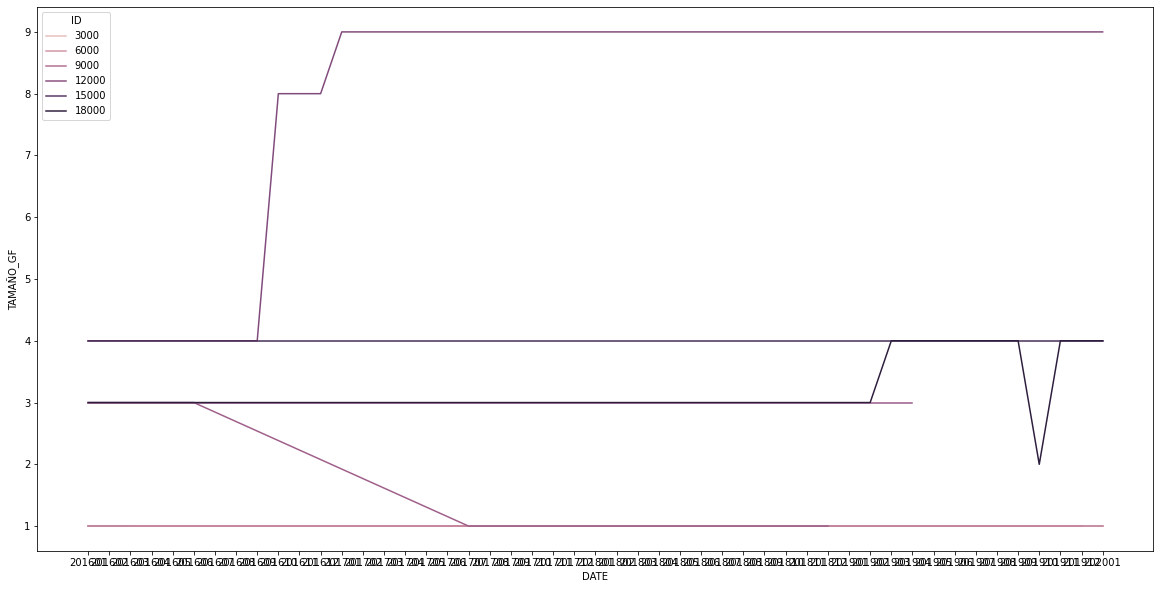

In [176]:
sns.lineplot(data=serie_gf_df[serie_gf_df['ID'].isin(ids_rnd)], x="DATE", y="TAMAÑO_GF", hue="ID")
plt.rcParams["figure.figsize"] = (30,10)

In [48]:
#         *yyyymm_generate(201601, 202001,'PORCENTAJE_BAJAS_GF_')
df_tmp = df[['ID', *yyyymm_generate(201601, 202001,'TAMAÑO_GF_')]]
df_tmp

,ID,TAMAÑO_GF_201601,TAMAÑO_GF_201602,TAMAÑO_GF_201603,TAMAÑO_GF_201604,TAMAÑO_GF_201605,TAMAÑO_GF_201606,TAMAÑO_GF_201607,TAMAÑO_GF_201608,TAMAÑO_GF_201609,...,TAMAÑO_GF_201904,TAMAÑO_GF_201905,TAMAÑO_GF_201906,TAMAÑO_GF_201907,TAMAÑO_GF_201908,TAMAÑO_GF_201909,TAMAÑO_GF_201910,TAMAÑO_GF_201911,TAMAÑO_GF_201912,TAMAÑO_GF_202001
0,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,45,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20256,20298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20257,20299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
20258,20300,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
20259,20301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,7.0,7.0,7.0,9.0,9.0,9.0,9.0,9.0


In [45]:
df.TAMAÑO_GF_202001.value_counts(bins=5, dropna=False)

(0.534, 94.0]     14497
(373.0, 466.0]       27
(94.0, 187.0]        23
(280.0, 373.0]       10
(187.0, 280.0]        0
Name: TAMAÑO_GF_202001, dtype: int64

<AxesSubplot:xlabel='TAMAÑO_GF_202001'>

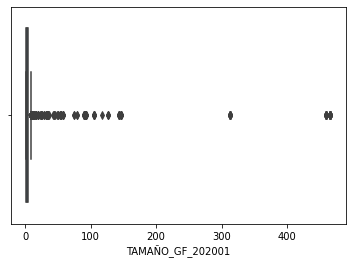

In [470]:
sns.boxplot(x=df.TAMAÑO_GF_202001[~df.TAMAÑO_GF_202001.isnull()])

**Conclusiones:**
1. La cantidad de nulos en *TAMAÑO_GF_yyyymm* decrece hasta el mes 201807, luego la cantidad de nulos empieza a aumentar
2. La cantidad de nulos en *PORCENTAJE_BAJAS_GF_yyyymm* tiene un crecimiento en cantidad de nulos.
2. 

### 4. Varibles económicas del Seguro
* INGRESO_yyyymm: Sueldo del mes a mes (yyyymm: 201710 - 202001)
* PRIMA_yyyy: **¿Monto pagado x el seguro? cual es la diferencia con pago, cuando puede ser mayor o menor que el pago?** (yyyy: 2016 - 2019)
* PRIMA_yyyymm: **¿¿¿¿????** (yyyymm: 201601 - 202001)
* PAGO_yyyymm: Monto de pago por el seguro en el mes (yyyymm: 201601 - 202001)
* DIAS_MORA_yyyymm: Dias de retraso en el pago del mes (yyyymm: 201601 - 202001)

In [437]:
#list(df.columns)
df2.RANGO_INGRESO_APOR.value_counts(dropna=False)

04.[2000 - 4000>    5619
03.[1000 - 2000>    4153
05.[4000 - 8000>    4094
06.8000 A MÁS       2225
NaN                 1809
02.[600 - 1000>     1798
01.<600              467
Name: RANGO_INGRESO_APOR, dtype: int64

### 5. VP Value, Proyecciónn del Modelo de Supervivencia
* vp_primas
* vp_siniestros
* vp_tecnico
* vp_gastos
* VP_OPERATIVO

In [431]:
df2[list(filter(lambda x: x.startswith('VP'), df2.columns))].describe()

,VP_PRIMAS,VP_SINIESTROS,VP_TECNICO,VP_GASTOS,VP_OPERATIVO
count,20165.000000,20165.000000,20165.000000,20165.000000,20165.000000
mean,5284.072991,3326.408760,1903.952684,1001.217049,903.076164
std,5992.168170,7571.044645,5550.447662,894.302518,5529.449298
min,225.837050,25.755638,-116059.050000,56.057346,-119612.020000
25%,1475.830300,279.316930,985.379520,416.023160,486.498080
50%,2815.303500,1012.149400,1586.284500,683.316960,910.177670
75%,6564.900900,3172.298800,3283.794700,1253.675300,2131.070100
max,42315.637000,125411.560000,28740.230000,11069.376000,23367.838000


In [ ]:
#from pandas_profiling import ProfileReport
#reporte = ProfileReport(df_null_clean.drop(['ID'], axis=1),title="Reporte",explorative=True)
#reporte.to_notebook_iframe()